In [70]:
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (summarize,
                         poly,
                         ModelSpec as MS)
from statsmodels.stats.anova import anova_lm
from pygam import (s as s_gam,
                   l as l_gam,
                   f as f_gam,
                   LinearGAM,
                   LogisticGAM)

from ISLP.transforms import (BSpline,
                             NaturalSpline)
from ISLP.models import bs, ns
from ISLP.pygam import (approx_lam,
                        degrees_of_freedom,
                        plot as plot_gam,
                        anova as anova_gam)
import seaborn as sns
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from ISLP.models import sklearn_sm
from matplotlib import pyplot as plt

In [9]:
wage = load_data('Wage')
y = wage['wage']
age = wage['age']

In [56]:
cross_vals = []
for i in range(1,10):
    poly_age = MS([poly('age', degree=i)]).fit(wage)
    M = sklearn_sm(sm.OLS)
    results = cross_validate(M, X=poly_age.transform(wage), y=y, cv=10)
    cross_vals.append(np.mean(results['test_score']))

In [55]:
results

{'fit_time': array([0.       , 0.       , 0.0015018, 0.       , 0.       ]),
 'score_time': array([0.00100017, 0.        , 0.00050211, 0.00100303, 0.        ]),
 'test_score': array([1754.72351747, 1529.83867166, 1449.9068158 , 1605.30730874,
        1648.81811427])}

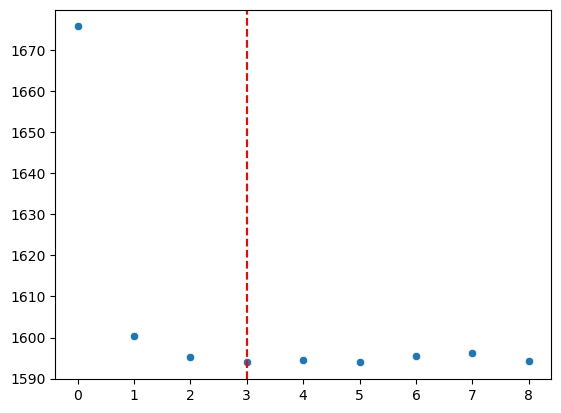

In [78]:
sns.scatterplot(cross_vals)
plt.axvline(np.argmin(cross_vals), color='red', linestyle='--')

In [67]:
models = [MS([poly('age', degree=d)]) 
          for d in range(1, 10)]
Xs = [model.fit_transform(wage) for model in models]
anova_lm(*[sm.OLS(y, X_).fit()
           for X_ in Xs])

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793430e+06,1.0,228786.010128,143.811827,2.128079e-32
2,2996.0,4.777674e+06,1.0,15755.693664,9.903818,1.665559e-03
3,2995.0,4.771604e+06,1.0,6070.152124,3.815616,5.086990e-02
4,2994.0,4.770322e+06,1.0,1282.563017,0.806202,3.693177e-01
5,2993.0,4.766389e+06,1.0,3932.257665,2.471765,1.160134e-01
6,2992.0,4.763834e+06,1.0,2555.281281,1.606216,2.051232e-01
7,2991.0,4.763707e+06,1.0,126.668985,0.079622,7.778293e-01
8,2990.0,4.756703e+06,1.0,7004.317139,4.402820,3.596326e-02


<Axes: xlabel='age', ylabel='wage'>

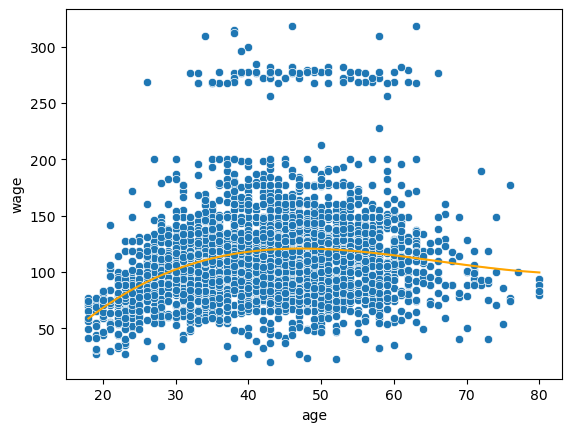

In [90]:
poly_age = MS([poly('age', degree=3)]).fit(wage)
M = sm.OLS(y, poly_age.transform(wage)).fit()
sns.lineplot(y=M.predict(), x=wage['age'], color='orange')
sns.scatterplot(y=y, x=wage['age'])

In [185]:
max_age = max(wage['age'])
min_age = min(wage['age']) 
cross_vals = []

for nb_cuts in range(2,50):
    edges = np.linspace(min_age, max_age, nb_cuts)
    cuts_df = wage.copy()
    for i in range(0, len(edges)-2):
        cuts_df[f'age_{edges[i]}-{edges[i+1]}'] = cuts_df['age'].between(edges[i], edges[i+1], inclusive="left")
    cuts_df[f'age_{edges[-1]}-{edges[-2]}'] = cuts_df['age'].between(edges[-2], edges[-1], inclusive="both")
    cuts_df = cuts_df.drop(columns = ['year', 'age', 'maritl', 'race', 'education', 'region', 'jobclass', 'health', 'health_ins', 'logwage', 'wage'])
    
    M = sklearn_sm(sm.OLS)
    results = cross_validate(M, X=cuts_df, y=y, cv=10)
    cross_vals.append(np.mean(results['test_score']))


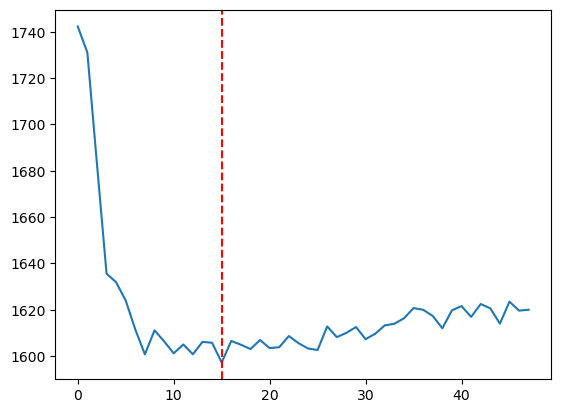

In [189]:
sns.lineplot(cross_vals)
plt.axvline(np.argmin(cross_vals), color='red', linestyle='--')

<Axes: xlabel='age', ylabel='wage'>

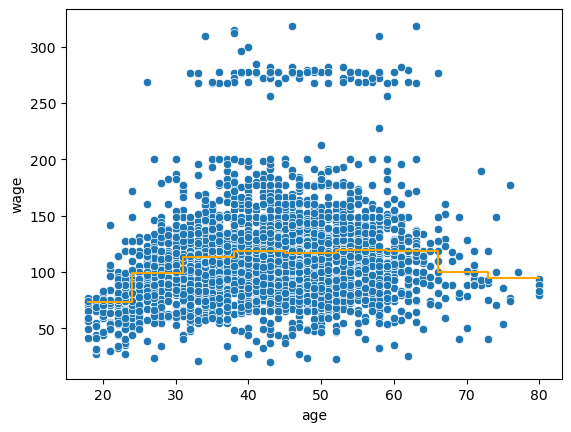

In [195]:
edges = np.linspace(min_age, max_age, 10)
cuts_df = wage.copy()
for i in range(0, len(edges)-2):
    cuts_df[f'age_{edges[i]}-{edges[i+1]}'] = cuts_df['age'].between(edges[i], edges[i+1], inclusive="left")
cuts_df[f'age_{edges[-1]}-{edges[-2]}'] = cuts_df['age'].between(edges[-2], edges[-1], inclusive="both")
cuts_df = cuts_df.drop(columns = ['year', 'age', 'maritl', 'race', 'education', 'region', 'jobclass', 'health', 'health_ins', 'logwage', 'wage'])
    
M = sm.OLS(y, cuts_df).fit()
sns.lineplot(y=M.predict(), x=wage['age'], color='orange', drawstyle='steps-pre')
sns.scatterplot(y=y, x=wage['age'])